In [20]:
from itertools import permutations, product

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std

import pickle

from ctgan import CTGANSynthesizer

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None


In [69]:
def saveModel(model, name, X_test, y_test, params=None, dir='curr_models', gradBoost=False, xgBoost=False):
    
    
    if not path.exists(f"{dir}/{name}.pkl"):
        print("does not exist")

        pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))
    else:
        predictions = model.predict(X_test)
        currAcc = accuracy_score(y_test, predictions)

        pickled_model = pickle.load(open(f'{dir}/{name}.pkl', 'rb'))
        
        if gradBoost:
            # get features here 
            cols_when_model_builds = pickled_model.feature_names_in_
            X_test=X_test[cols_when_model_builds]
        elif xgBoost:
            # put features into the same order that the model was trained in
            cols_when_model_builds = pickled_model.get_booster().feature_names
            X_test=X_test[cols_when_model_builds]
        
        # .values?
        
        picklePredictions=pickled_model.predict(X_test)
        pickleAcc=accuracy_score(y_test, picklePredictions)
        
        if currAcc > pickleAcc:
            print("update!")

            # TP, FP, FN, TN
            print(confusion_matrix(y_test, picklePredictions).ravel())

            print("curr", currAcc, "pickle", pickleAcc)
            pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))

            if params != None:
                pickle.dump(params, open(f'{dir}/{name}-params.pkl', 'wb'))
        else:
            print("no update")
            print("curr", currAcc, "pickle", pickleAcc)
            
            # TP, FP, FN, TN
            print(confusion_matrix(y_test, picklePredictions).ravel())

            model=pickled_model
    return model

In [51]:
df = pd.read_csv('info.csv')
# print(df.loc[:, df.columns != 'isZoonotic'])
# print(df)
# print(len(df.columns))
# print(negganmodel.sample(10))
isZoonotic = df.loc[df['isZoonotic']==1][:1200]
isZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(isZoonotic)

posGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
posGanModel.fit(isZoonotic)

# check if current model is better than pickled model
posGanModel.save('curr_models/posGanModel.pkl')

          tggc      ttcc      tatg  ...      cttg      ctat      tctt
0     0.329787  0.297872  0.617021  ...  0.148936  0.393617  0.170213
1     0.377551  0.255102  0.744898  ...  0.153061  0.367347  0.112245
2     0.462366  0.279570  0.161290  ...  0.182796  0.193548  0.118280
3     0.455446  0.188119  0.475248  ...  0.188119  0.386139  0.138614
4     0.666667  0.333333  0.575758  ...  0.636364  0.515152  0.424242
...        ...       ...       ...  ...       ...       ...       ...
1195  0.404762  0.333333  0.571429  ...  0.261905  0.357143  0.202381
1196  0.417582  0.252747  0.637363  ...  0.208791  0.274725  0.153846
1197  0.341463  0.146341  0.329268  ...  0.207317  0.231707  0.231707
1198  0.192308  0.153846  0.461538  ...  0.166667  0.320513  0.230769
1199  0.226190  0.273810  0.428571  ...  0.166667  0.357143  0.285714

[1200 rows x 256 columns]
Epoch 1, Loss G:  1.1869,Loss D: -5.0061
Epoch 2, Loss G: -2.9529,Loss D:  0.5745
Epoch 3, Loss G: -3.6013,Loss D: -0.6512
Epoch 4, L

In [50]:
notZoonotic = df.loc[df['isZoonotic']==0][:3000]
notZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(notZoonotic)

negGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
negGanModel.fit(notZoonotic)
negGanModel.save('curr_models/negGanModel.pkl')

          tggc      ttcc      tatg  ...      cttg      ctat      tctt
0     0.329787  0.297872  0.617021  ...  0.148936  0.393617  0.170213
1     0.377551  0.255102  0.744898  ...  0.153061  0.367347  0.112245
2     0.462366  0.279570  0.161290  ...  0.182796  0.193548  0.118280
3     0.455446  0.188119  0.475248  ...  0.188119  0.386139  0.138614
4     0.666667  0.333333  0.575758  ...  0.636364  0.515152  0.424242
...        ...       ...       ...  ...       ...       ...       ...
1195  0.404762  0.333333  0.571429  ...  0.261905  0.357143  0.202381
1196  0.417582  0.252747  0.637363  ...  0.208791  0.274725  0.153846
1197  0.341463  0.146341  0.329268  ...  0.207317  0.231707  0.231707
1198  0.192308  0.153846  0.461538  ...  0.166667  0.320513  0.230769
1199  0.226190  0.273810  0.428571  ...  0.166667  0.357143  0.285714

[1200 rows x 256 columns]
Epoch 1, Loss G:  1.8207,Loss D: -5.4888
Epoch 2, Loss G: -1.7336,Loss D: -0.0555
Epoch 3, Loss G: -1.9224,Loss D:  1.3800
Epoch 4, L

In [52]:
negGanModel.sample(100)

,tggc,ttcc,tatg,gtat,aatg,acag,atgg,tact,tcaa,aggc,cggc,accc,agcg,acct,cggt,agtc,ggag,gtga,aggg,aaga,taga,ccct,acaa,tgag,acta,caac,cagc,gata,ctag,cgat,gccc,gtaa,ttat,tgcg,ttgg,tggt,aaag,agcc,cacg,ccgg,...,gcct,gcgt,ggac,tcga,ttag,ggtt,gatc,agaa,cctg,cccc,aagt,cgaa,cggg,ccgt,cttt,gtgg,tttc,atct,tcct,gtgt,tctc,acgg,cgca,taca,ttac,atag,gcga,ccat,gtcc,tatt,ggca,gacc,agct,agta,tatc,acgt,cact,cttg,ctat,tctt
0,0.472322,0.661450,0.005978,0.846969,0.750095,0.322174,0.308445,0.350308,0.575924,0.672069,0.024612,0.270464,0.099759,0.123451,0.049129,0.354501,0.386528,0.730948,0.550408,0.822186,0.189669,0.609759,0.315737,0.511179,0.286729,0.341372,0.636368,0.727531,0.177500,-0.012138,0.059506,0.316552,-0.035234,0.062045,-0.040983,0.526447,0.686138,0.077469,0.181407,0.102878,...,0.334554,0.070460,0.224146,0.122280,0.242956,0.290068,0.342674,0.880133,0.398292,0.675336,0.623770,0.120066,0.061607,0.069435,0.442266,0.582136,0.483061,0.464966,0.319861,0.917065,0.588941,0.031924,0.210028,0.936870,0.498774,0.063906,0.076896,0.469178,0.186630,0.179499,0.413927,0.548473,0.496797,0.586708,0.616658,0.057951,0.480616,0.377244,0.413619,0.265727
1,0.648367,0.418625,0.141495,0.012746,0.791049,0.782488,0.607024,0.372029,0.342195,0.617628,0.132178,0.535099,-0.011121,0.500761,-0.030641,0.474983,0.386665,0.355908,0.803094,0.870483,0.213335,1.071180,0.852902,0.519056,0.268205,0.582111,0.516832,0.260086,0.248226,0.019213,0.772589,0.232803,0.035175,0.134454,0.506986,0.716464,0.324347,0.389975,0.248306,0.135278,...,0.381452,0.168773,0.393117,0.288194,0.001184,0.155895,-0.035418,0.938023,0.393512,-0.035442,0.403338,-0.020016,0.023745,0.220651,0.517240,0.193853,0.404493,0.384084,0.492232,0.358603,0.637485,0.035491,0.367694,0.408655,0.143658,0.025152,0.238126,0.500575,0.352814,0.148441,0.264571,0.293456,0.563584,0.040166,0.192890,0.085006,0.569171,0.361487,0.418903,0.280599
2,0.460238,0.221713,0.373972,0.378100,0.208968,0.675810,1.108282,0.620698,0.524280,0.362923,0.125631,0.536871,0.159276,0.676046,0.294507,0.479511,0.705838,0.143872,0.024452,0.745305,0.123018,0.280866,0.946671,1.045478,0.304123,1.027852,0.237805,0.028099,0.071341,0.046423,0.769223,0.282714,0.623816,-0.042047,0.186044,0.503797,0.606729,0.041253,-0.000319,0.021303,...,0.212181,0.172048,0.115821,0.127775,-0.068845,0.361970,-0.055204,0.717158,0.326835,0.027799,0.306157,0.029995,0.002340,0.284578,0.582685,0.536701,0.443006,0.211164,0.484973,0.262359,0.584694,0.092853,0.017881,0.526899,0.427813,0.111537,0.640033,0.518772,0.506605,0.675622,0.479519,0.375434,0.299529,0.137947,0.201120,0.086669,0.282365,0.177170,0.232475,0.395859
3,0.884530,0.275633,0.468271,0.135213,0.464251,0.704316,0.457763,0.467102,0.740492,0.392388,0.053859,0.618819,0.108772,0.266047,0.029800,0.380389,0.688657,0.499768,0.480561,0.873203,0.176565,0.338616,0.355949,0.516013,0.359544,0.778915,0.599294,0.387781,0.471745,0.196814,0.614863,0.565790,-0.010889,0.005028,0.415546,0.343784,0.602273,0.394430,0.154361,0.394833,...,0.306906,0.276255,0.587816,0.106340,0.240838,0.009458,0.299208,-0.012088,0.462746,0.863154,0.476364,0.060870,0.006726,0.087170,0.565271,0.419776,0.342614,0.256867,0.490349,0.301749,0.526777,0.195350,0.161066,0.751863,0.601834,0.187816,0.057350,0.284113,0.239496,0.047083,0.388304,0.412965,0.409703,0.463214,0.069771,0.154859,0.230324,0.459936,0.524665,0.247469
4,0.400521,0.453404,0.091850,0.155069,0.775114,0.467084,0.481224,0.431508,0.517324,0.415679,0.165963,0.585886,-0.010441,0.337022,0.055082,0.205321,0.610097,0.292915,0.455455,0.836974,0.045120,0.741251,0.653997,0.220749,0.646298,0.754766,0.070199,0.288284,-0.010259,0.052121,-0.031458,0.190904,0.240753,0.145900,0.288160,0.306975,0.636921,0.394364,0.298356,0.228775,...,0.383240,0.171474,0.255039,0.076002,0.040280,0.199206,0.124423,0.217303,0.575051,0.463282,0.284472,0.154506,0.018667,0.396974,0.375016,0.470750,0.561666,0.455013,0.396546,0.478426,0.609262,0.158234,0.125127,0.675609,0.442116,0.444490,0.209888,0.527408,0.093149,0.247838,0.452869,0.580363,0.543215,0.045347,0.

In [56]:
print(type(posGanModel.sample(100)))
print(posGanModel.sample(10).columns)

<class 'pandas.core.frame.DataFrame'>
Index(['tggc', 'ttcc', 'tatg', 'gtat', 'aatg', 'acag', 'atgg', 'tact', 'tcaa',
       'aggc',
       ...
       'ggca', 'gacc', 'agct', 'agta', 'tatc', 'acgt', 'cact', 'cttg', 'ctat',
       'tctt'],
      dtype='object', length=256)


In [67]:
n_syntheticPos = 100
n_syntheticNeg = 100

# consider storing NON-normalized data in CSV? Then calculate normalized values later for more accuracy

x_orig= pd.concat([negGanModel.sample(n_syntheticNeg), posGanModel.sample(n_syntheticPos)], axis=0, ignore_index=True)
# add y orig

y_orig = pd.concat([pd.DataFrame(np.zeros(n_syntheticNeg)), pd.DataFrame(np.ones(n_syntheticPos))], axis=0, ignore_index=True)

# print(x_orig.to_string())
# print(y_orig.to_string())

# print(df.loc[:, df.columns != 'isZoonotic'])

# add synthetic data
# print(pd.concat([df.loc[:, df.columns != 'isZoonotic'], x_orig], axis=0, ignore_index=True).to_string())
# print(pd.concat([df['isZoonotic'], y_orig], axis=0, ignore_index=True).to_string())

X_vals = pd.concat([df.loc[:, df.columns != 'isZoonotic'], x_orig], axis=0, ignore_index=True)
Y_vals = pd.concat([df['isZoonotic'], y_orig], axis=0, ignore_index=True)


X_train, X_test, y_train, y_test = train_test_split(X_vals, Y_vals, test_size=0.2, random_state=1)
# for col in df.columns:
#     col != 'isZoonotic' and X_train[col].isnull().sum() != 0 and print(X_train[col].isnull().sum())

9628


In [70]:
lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(X_train, y_train)

saveModel(lrmodel, "lrmodel", X_test, y_test)

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


update!
[1597   50   90  189]
curr 0.9288681204569055 pickle 0.9273104880581516


LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [71]:
# all 0s for some reason
print(X_test[:10])
predictions = lrmodel.predict(X_test)
print(accuracy_score(y_test, predictions))

          tggc      ttcc      tatg  ...      cttg      ctat      tctt
6018  0.240741  0.500000  0.342593  ...  0.629630  0.398148  1.000000
4363  0.276923  0.400000  0.476923  ...  0.400000  0.323077  0.323077
941   0.238095  0.142857  0.392857  ...  0.250000  0.392857  0.238095
4960  0.400000  0.186667  0.346667  ...  0.373333  0.280000  0.520000
6435  0.192308  0.192308  0.096154  ...  0.182692  0.019231  0.211538
7516  0.350877  0.473684  0.333333  ...  0.298246  0.192982  0.385965
3100  0.193330  0.399427  0.235800  ...  0.288692  0.252996  0.672225
1729  0.265287  0.144873  0.026341  ...  0.038570  0.036689  0.032926
4530  0.121921  0.061576  0.273399  ...  0.104680  0.190887  0.183498
4656  0.410256  0.461538  0.487179  ...  0.384615  0.153846  0.358974

[10 rows x 256 columns]
0.9288681204569055


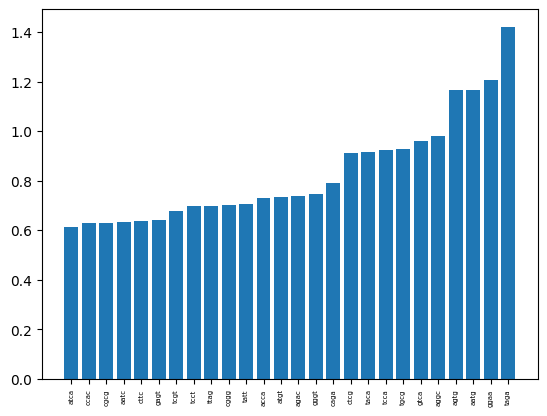

In [72]:
results = lrmodel.coef_[0]

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=5)

plt.bar([x[0] for x in res[230:]], [x[1] for x in res[230:]])
plt.show()

In [109]:
def getRealLength(kmer):
    print(X_test.iloc[0])
    sums = [kmer-1+((X_test.iloc[x].sum())/kmer) for x in range(len(X_test))]
    print(sums)

In [73]:
knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
# knn = KNeighborsClassifier(n_neighbors=5)

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [74]:
predictions = knntest.predict(X_test)
print(predictions[:10])
print(accuracy_score(y_test, predictions))
saveModel(knntest, "knn", X_test, y_test)

[0. 0. 1. 1. 1. 0. 1. 0. 0. 0.]
0.8883696780893042
no update
curr 0.8883696780893042 pickle 0.9018691588785047
[1482  165   24  255]


BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [75]:
randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [76]:
saveModel(randforest, "randforest", X_test, y_test)

predictions = randforest.predict(X_test)
print(accuracy_score(y_test, predictions))

# for i in range(1000):
#     predictions[i] != y_test_list[i] and print(predictions[i], "vs", y_test_list[i])

no update
curr 0.9060228452751817 pickle 0.9257528556593977
[1562   85   58  221]
0.9060228452751817


In [77]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(accuracy_score(y_test, preds))


0.9060228452751817


In [80]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":120, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8
    # "warm_start":True
}


# careful with WARM START - only works after a lot of iterations
for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
    )

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    cols_when_model_builds = gradBoost.feature_names_in_
    X_test=X_test[cols_when_model_builds]
    
    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters, gradBoost=True, dir="synthetic_data_testing")

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.05
Accuracy score (validation): 0.946
does not exist


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.075
Accuracy score (validation): 0.949
update!
[1640    7   97  182]
curr 0.9491173416407062 pickle 0.9460020768431984


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.1
Accuracy score (validation): 0.949
no update
curr 0.9491173416407062 pickle 0.9491173416407062
[1635   12   86  193]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.15
Accuracy score (validation): 0.947
no update
curr 0.9470404984423676 pickle 0.9491173416407062
[1635   12   86  193]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.2
Accuracy score (validation): 0.952
update!
[1635   12   86  193]
curr 0.9517133956386293 pickle 0.9491173416407062


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.25
Accuracy score (validation): 0.950
no update
curr 0.9496365524402908 pickle 0.9517133956386293
[1624   23   70  209]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.3
Accuracy score (validation): 0.954
update!
[1624   23   70  209]
curr 0.9537902388369678 pickle 0.9517133956386293


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.35
Accuracy score (validation): 0.949
no update
curr 0.9485981308411215 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.4
Accuracy score (validation): 0.950
no update
curr 0.9501557632398754 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.45
Accuracy score (validation): 0.926
no update
curr 0.9257528556593977 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.5
Accuracy score (validation): 0.945
no update
curr 0.9454828660436138 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.55
Accuracy score (validation): 0.949
no update
curr 0.9491173416407062 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.6
Accuracy score (validation): 0.945
no update
curr 0.944963655244029 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.65
Accuracy score (validation): 0.888
no update
curr 0.8878504672897196 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.7
Accuracy score (validation): 0.878
no update
curr 0.8779854620976116 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.75
Accuracy score (validation): 0.908
no update
curr 0.9080996884735203 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.8
Accuracy score (validation): 0.913
no update
curr 0.9132917964693665 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  0.85
Accuracy score (validation): 0.903
no update
curr 0.9029075804776739 pickle 0.9537902388369678
[1627   20   69  210]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Learning rate:  1
Accuracy score (validation): 0.710
no update
curr 0.7102803738317757 pickle 0.9537902388369678
[1627   20   69  210]


In [81]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "subsample":0.8,
    'lambda': 0.5, # regularization?
    'alpha': 0.5
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    # ALWAYS reset feature names
    cols_when_model_builds = xgBoost.get_booster().feature_names
    X_test=X_test[cols_when_model_builds]

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True, dir="synthetic_data_testing")

Learning rate:  0.05
Accuracy score (validation): 0.953
does not exist
Learning rate:  0.075
Accuracy score (validation): 0.960
update!
[1627   20   71  208]
curr 0.9595015576323987 pickle 0.9527518172377986
Learning rate:  0.1
Accuracy score (validation): 0.955
no update
curr 0.9548286604361371 pickle 0.9595015576323987
[1632   15   63  216]
Learning rate:  0.15
Accuracy score (validation): 0.958
no update
curr 0.9584631360332295 pickle 0.9595015576323987
[1632   15   63  216]
Learning rate:  0.2
Accuracy score (validation): 0.956
no update
curr 0.9558670820353063 pickle 0.9595015576323987
[1632   15   63  216]
Learning rate:  0.25
Accuracy score (validation): 0.957
no update
curr 0.9574247144340602 pickle 0.9595015576323987
[1632   15   63  216]
Learning rate:  0.3
Accuracy score (validation): 0.958
no update
curr 0.9584631360332295 pickle 0.9595015576323987
[1632   15   63  216]
Learning rate:  0.35
Accuracy score (validation): 0.962
update!
[1632   15   63  216]
curr 0.961578400830

In [82]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

best_xgboost = pickle.load(open('curr_models/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open('curr_models/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open('curr_models/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open('curr_models/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open('curr_models/randforest.pkl', 'rb'))

print(best_xgboost_params)
print(best_gradBoost_params)

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)).ravel())


cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)).ravel())
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)))


print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(y_test, best_rF.predict(X_test)))
print(confusion_matrix(y_test, best_rF.predict(X_test)).ravel())


print("Best lR Accuracy: ", accuracy_score(y_test, lrmodel.predict(X_test)))
print("Balanced lR Accuracy: ", balanced_accuracy_score(y_test, lrmodel.predict(X_test)))
print(confusion_matrix(y_test, lrmodel.predict(X_test)).ravel())


{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'subsample': 0.8, 'lambda': 0.5, 'alpha': 0.5, 'learning_rate': 0.25}
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}
Best XG Accuracy:  0.9600207684319834
Balanced XG Accuracy:  0.8798695575533227
[1627   20   69  210]
Best GB Accuracy:  0.9537902388369678
Balanced GB Accuracy:  0.8702724406055977
[1627   20   69  210]
[[1627   20]
 [  69  210]]
Best rF Accuracy:  0.9257528556593977
Balanced rF Accuracy:  0.8702528546526431
[1562   85   58  221]
Best lR Accuracy:  0.9288681204569055
Balanced lR Accuracy:  0.8244413106919717
[1600   47   90  189]


precision recall: 0.9012311175413683
[4.82472914e-02 5.17716274e-04 9.93906573e-01 ... 6.57746878e-05
 1.43246377e-01 1.34953266e-04]


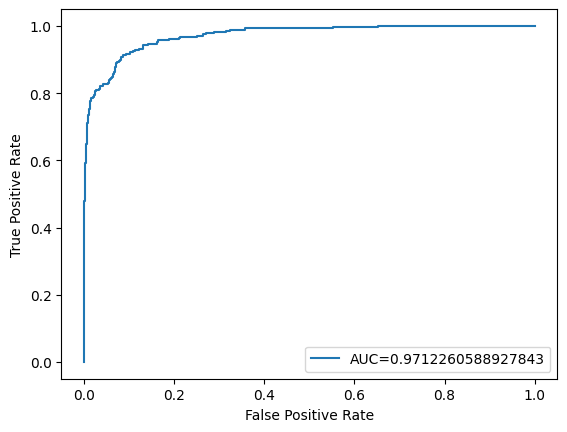

In [83]:
# ALWAYS reset X columns to the right order
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


precision recall: 0.9367884251285298
[4.4796215e-03 6.6172186e-05 9.9992716e-01 ... 1.1503436e-04 3.1414822e-02
 3.8117574e-05]


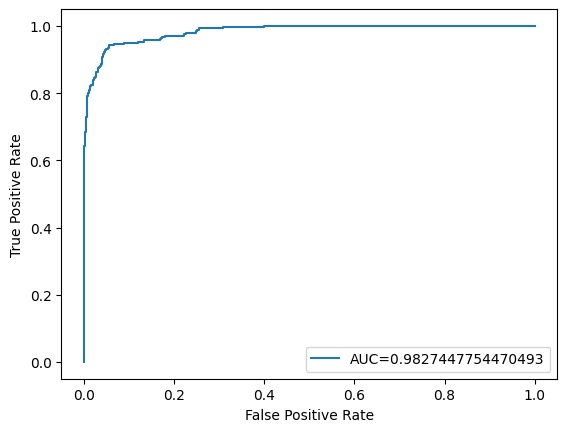

In [90]:
# ALWAYS reset X columns to the right order

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_xgboost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_xgboost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [91]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_xgboost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.936 (0.011)


In [86]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vecto

Accuracy: 0.938 (0.012)


0.9367884251285298
[0.6 0.  0.9 ... 0.  0.6 0. ]


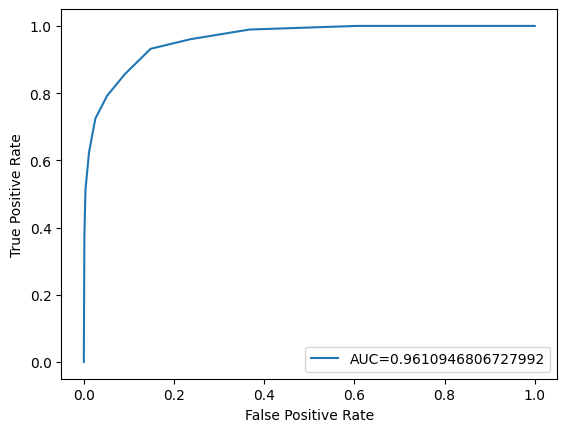

In [87]:
y_pred_proba = best_rF.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)
y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_xgboost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)

print(aaa)
print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

[0.0147458  0.00089454 0.79553342 ... 0.04186395 0.59232453 0.00169825]


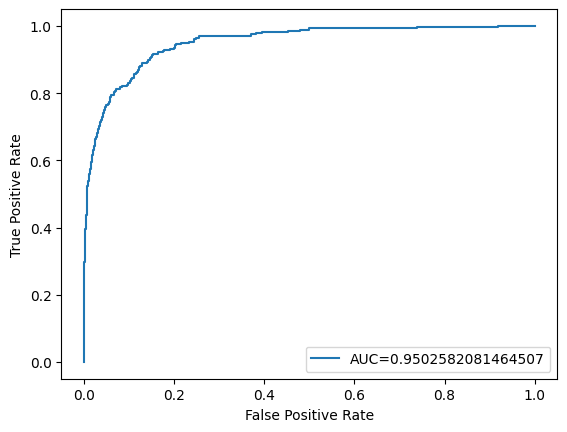

In [88]:
y_pred_proba = lrmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [75]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.906 (0.023)


In [76]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lrmodel, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.937 (0.016)


In [89]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(knntest, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWar

Accuracy: 0.856 (0.025)
